In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDPM
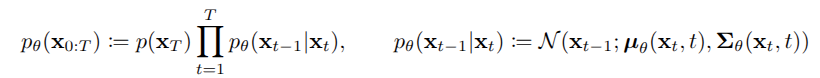
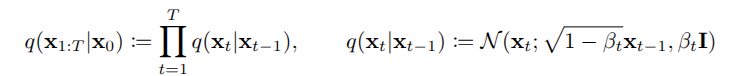
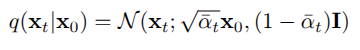
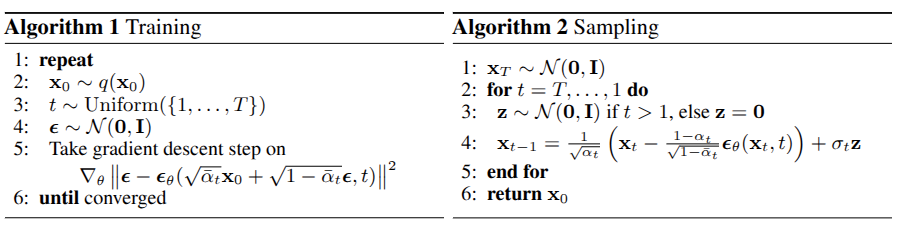

# TODO
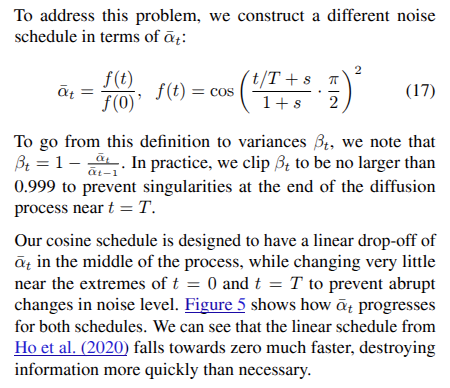

In [ ]:
def gather(x: torch.Tensor, t: Union[int, torch.Tensor]):
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x.device)
    elif isinstance(t, list):
        t = torch.tensor(t, dtype=torch.long, device=x.device)
    elif isinstance(t, torch.Tensor):
        t = t.to(dtype=torch.long, device=x.device)
    else:
        raise ValueError("Unsupported type for t")

    temp = x.gather(0, t)
    return temp.reshape(-1, 1, 1, 1)


class DDPM:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        n_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
    ):
        super().__init__()
        self.n_steps = n_steps
        self.model = model
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

    def q(self, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the forward diffusion process q(x_t | x_{t-1}).
        """
        alpha_bar_t = gather(self.alpha_bar, t)
        mean = torch.sqrt(alpha_bar_t) * x_0
        var = 1.0 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x_0, t, eps=None):
        """
        Sample from the forward diffusion process q(x_t | x_0).
        """
        if eps is None:
            eps = torch.randn_like(x_0)
        mean, var = self.q(x_0, t)
        return mean + torch.sqrt(var) * eps

    def p_sample(self, x_t, t):
        eps_theta = self.model(x_t, t)
        alpha_bar_t = gather(self.alpha_bar, t)
        alpha_t = gather(self.alphas, t)
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t) * eps_theta
        )
        var = gather(self.betas, t)
        eps = torch.randn_like(x_t, device=self.device)
        return mean + torch.sqrt(var) * eps

    def loss(self, x_0, noise=None):
        """
        Compute the loss for the model.
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        t = torch.randint(0, self.n_steps, (x_0.size(0),), device=self.device)
        x_t = self.q_sample(x_0, t, noise)
        eps_theta = self.model(x_t, t)
        return F.mse_loss(eps_theta, noise)

    def sample(self, n_samples=1, image_size=(1, 28, 28), xt=None):
        if xt is not None:
            x_t = xt.to(self.device)
        else:
            x_t = torch.randn(n_samples, *image_size).to(self.device)

        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x_t = self.p_sample(x_t, t_batch)  # assumes p_sample does noise addition

        return torch.clamp(x_t, -1.0, 1.0)

# UNet
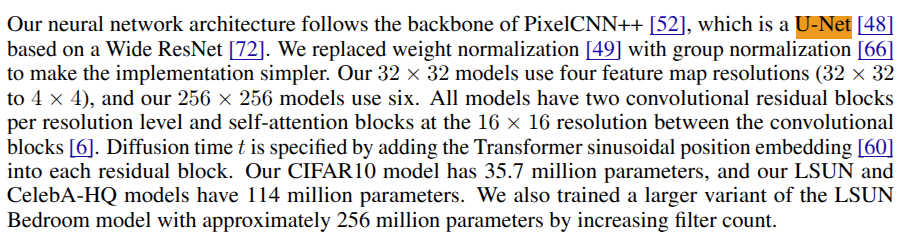
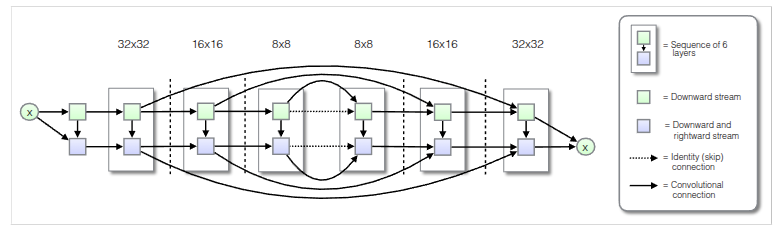

In [ ]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, groups=8):
        super().__init__()
        self.group_norm1 = nn.GroupNorm(groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.group_norm2 = nn.GroupNorm(groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_emb = nn.Linear(time_dim, out_channels)
        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t):
        h = self.group_norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.group_norm2(h)
        h += self.time_emb(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1).permute(0, 2, 1)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)

        attn = torch.bmm(q, k) * (C**-0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return x + self.proj_out(out)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        # Downsampling
        self.down1 = nn.ModuleList(
            [
                ResidualBlock(in_channels, base_channels, time_dim, groups=1),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )
        self.down2 = nn.ModuleList(
            [
                ResidualBlock(base_channels, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels * 2, time_dim),
            ]
        )

        # Middle
        self.mid = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels * 4, time_dim),
                SelfAttentionBlock(base_channels * 4),
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
            ]
        )

        # Upsampling
        self.up2 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels, time_dim),
            ]
        )
        self.up1 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels, time_dim),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )

        self.final_conv = nn.Conv2d(base_channels, out_channels, 3, padding=1)

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t = self.time_mlp(t)
        x1 = []

        # Downsample path
        # Block 1 (28x28 -> 28x28)
        for block in self.down1:
            x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 14x14

        # Block 2 (14x14 -> 14x14)
        for block in self.down2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 7x7

        # Middle (7x7 -> 7x7)
        for block in self.mid:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Upsample path
        # Block 2 (7x7 -> 14x14)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Block 1 (14x14 -> 28x28)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up1:
            x = block(x, t)

        return self.final_conv(x)


# model = UNet()
# x = torch.randn(8, 1, 28, 28)  # MNIST batch
# t = torch.randint(0, 1000, (8,))  # Random timesteps
# output = model(x, t)
# print(output.shape)  # Should be (8, 1, 28, 28)

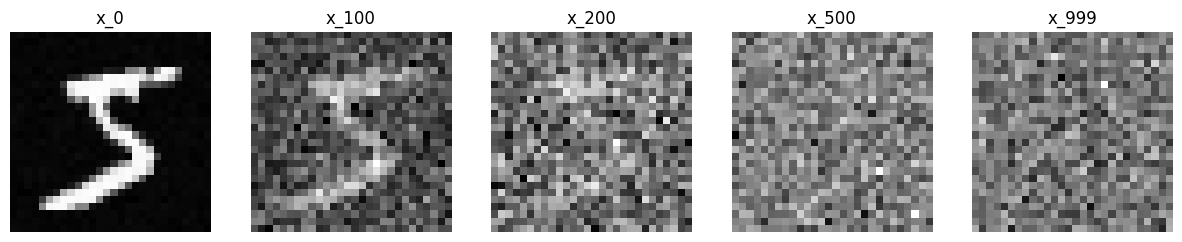

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("samples", exist_ok=True)

config = {
    "batch_size": 1280,
    "epochs": 200,
    "lr": 1e-4,
    "n_steps": 1000,
    "weight_decay": 1e-5,
    "max_grad_norm": 1.0,
    "save_interval": 50,
}

# Data augmentation
transform = transforms.Compose(
    [
        transforms.RandomRotation(5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Initialization
model = UNet().to(device)
diffusion = DDPM(model, device, n_steps=config["n_steps"])
optimizer = torch.optim.Adam(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
sampled_image = dataloader.dataset.data[:1].unsqueeze(1).float() / 255.0

timesteps = [0, 100, 200, 500, 999]
sampled_images = []

for t in timesteps:
    sampled_image = diffusion.q_sample(
        sampled_image.unsqueeze(0).to(device), t=torch.tensor([t]).to(device)
    )
    sampled_images.append(sampled_image.squeeze().cpu())

# Plot the sampled images
plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip(timesteps, sampled_images)):
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"x_{t}")
    plt.axis("off")
plt.show()

Epoch 1/200:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/200: 100%|██████████| 47/47 [00:06<00:00,  7.60it/s, Loss=0.1101]


Epoch 1 | Avg Loss: 0.3362


Epoch 2/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0740]


Epoch 2 | Avg Loss: 0.0942


Epoch 3/200: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0595]


Epoch 3 | Avg Loss: 0.0678


Epoch 4/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0549]


Epoch 4 | Avg Loss: 0.0568


Epoch 5/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0489]


Epoch 5 | Avg Loss: 0.0505


Epoch 6/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0621]


Epoch 6 | Avg Loss: 0.0523


Epoch 7/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0427]


Epoch 7 | Avg Loss: 0.0462


Epoch 8/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0439]


Epoch 8 | Avg Loss: 0.0437


Epoch 9/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0380]


Epoch 9 | Avg Loss: 0.0415


Epoch 10/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0399]


Epoch 10 | Avg Loss: 0.0402


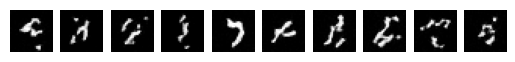

Epoch 11/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0398]


Epoch 11 | Avg Loss: 0.0389


Epoch 12/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0375]


Epoch 12 | Avg Loss: 0.0375


Epoch 13/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0378]


Epoch 13 | Avg Loss: 0.0383


Epoch 14/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0373]


Epoch 14 | Avg Loss: 0.0364


Epoch 15/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0359]


Epoch 15 | Avg Loss: 0.0359


Epoch 16/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0349]


Epoch 16 | Avg Loss: 0.0347


Epoch 17/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0340]


Epoch 17 | Avg Loss: 0.0349


Epoch 18/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0339]


Epoch 18 | Avg Loss: 0.0343


Epoch 19/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0362]


Epoch 19 | Avg Loss: 0.0340


Epoch 20/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0331]


Epoch 20 | Avg Loss: 0.0334


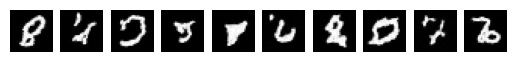

Epoch 21/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0318]


Epoch 21 | Avg Loss: 0.0340


Epoch 22/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0320]


Epoch 22 | Avg Loss: 0.0339


Epoch 23/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0324]


Epoch 23 | Avg Loss: 0.0329


Epoch 24/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0345]


Epoch 24 | Avg Loss: 0.0322


Epoch 25/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0326]


Epoch 25 | Avg Loss: 0.0318


Epoch 26/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0303]


Epoch 26 | Avg Loss: 0.0315


Epoch 27/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0319]


Epoch 27 | Avg Loss: 0.0315


Epoch 28/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0316]


Epoch 28 | Avg Loss: 0.0315


Epoch 29/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0285]


Epoch 29 | Avg Loss: 0.0313


Epoch 30/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0279]


Epoch 30 | Avg Loss: 0.0307


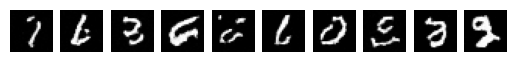

Epoch 31/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0408]


Epoch 31 | Avg Loss: 0.0330


Epoch 32/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0310]


Epoch 32 | Avg Loss: 0.0328


Epoch 33/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0308]


Epoch 33 | Avg Loss: 0.0309


Epoch 34/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0304]


Epoch 34 | Avg Loss: 0.0307


Epoch 35/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0280]


Epoch 35 | Avg Loss: 0.0304


Epoch 36/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0287]


Epoch 36 | Avg Loss: 0.0304


Epoch 37/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0289]


Epoch 37 | Avg Loss: 0.0301


Epoch 38/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0295]


Epoch 38 | Avg Loss: 0.0296


Epoch 39/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0293]


Epoch 39 | Avg Loss: 0.0296


Epoch 40/200: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0300]


Epoch 40 | Avg Loss: 0.0293


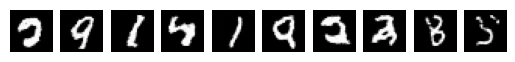

Epoch 41/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0310]


Epoch 41 | Avg Loss: 0.0295


Epoch 42/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0284]


Epoch 42 | Avg Loss: 0.0296


Epoch 43/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0273]


Epoch 43 | Avg Loss: 0.0290


Epoch 44/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0301]


Epoch 44 | Avg Loss: 0.0292


Epoch 45/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0302]


Epoch 45 | Avg Loss: 0.0293


Epoch 46/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0283]


Epoch 46 | Avg Loss: 0.0290


Epoch 47/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0274]


Epoch 47 | Avg Loss: 0.0288


Epoch 48/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0291]


Epoch 48 | Avg Loss: 0.0287


Epoch 49/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0276]


Epoch 49 | Avg Loss: 0.0287


Epoch 50/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0305]


Epoch 50 | Avg Loss: 0.0287


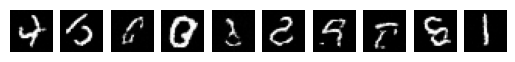

Epoch 51/200: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0264]


Epoch 51 | Avg Loss: 0.0284


Epoch 52/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0261]


Epoch 52 | Avg Loss: 0.0284


Epoch 53/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0310]


Epoch 53 | Avg Loss: 0.0286


Epoch 54/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0272]


Epoch 54 | Avg Loss: 0.0283


Epoch 55/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0290]


Epoch 55 | Avg Loss: 0.0280


Epoch 56/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0281]


Epoch 56 | Avg Loss: 0.0282


Epoch 57/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0291]


Epoch 57 | Avg Loss: 0.0281


Epoch 58/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0291]


Epoch 58 | Avg Loss: 0.0279


Epoch 59/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0307]


Epoch 59 | Avg Loss: 0.0279


Epoch 60/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0288]


Epoch 60 | Avg Loss: 0.0278


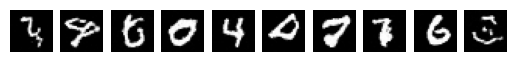

Epoch 61/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0272]


Epoch 61 | Avg Loss: 0.0280


Epoch 62/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0283]


Epoch 62 | Avg Loss: 0.0277


Epoch 63/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0291]


Epoch 63 | Avg Loss: 0.0286


Epoch 64/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0278]


Epoch 64 | Avg Loss: 0.0295


Epoch 65/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0283]


Epoch 65 | Avg Loss: 0.0275


Epoch 66/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0280]


Epoch 66 | Avg Loss: 0.0273


Epoch 67/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0273]


Epoch 67 | Avg Loss: 0.0274


Epoch 68/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0269]


Epoch 68 | Avg Loss: 0.0275


Epoch 69/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0256]


Epoch 69 | Avg Loss: 0.0273


Epoch 70/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0264]


Epoch 70 | Avg Loss: 0.0272


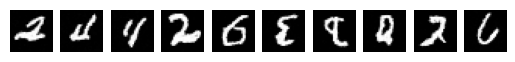

Epoch 71/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0247]


Epoch 71 | Avg Loss: 0.0270


Epoch 72/200: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0264]


Epoch 72 | Avg Loss: 0.0271


Epoch 73/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0281]


Epoch 73 | Avg Loss: 0.0270


Epoch 74/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0279]


Epoch 74 | Avg Loss: 0.0272


Epoch 75/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0246]


Epoch 75 | Avg Loss: 0.0271


Epoch 76/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0264]


Epoch 76 | Avg Loss: 0.0270


Epoch 77/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0252]


Epoch 77 | Avg Loss: 0.0271


Epoch 78/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0262]


Epoch 78 | Avg Loss: 0.0269


Epoch 79/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0284]


Epoch 79 | Avg Loss: 0.0268


Epoch 80/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0256]


Epoch 80 | Avg Loss: 0.0268


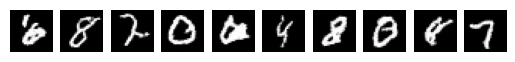

Epoch 81/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0253]


Epoch 81 | Avg Loss: 0.0268


Epoch 82/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0261]


Epoch 82 | Avg Loss: 0.0266


Epoch 83/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0274]


Epoch 83 | Avg Loss: 0.0267


Epoch 84/200: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0266]


Epoch 84 | Avg Loss: 0.0270


Epoch 85/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0279]


Epoch 85 | Avg Loss: 0.0279


Epoch 86/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0269]


Epoch 86 | Avg Loss: 0.0274


Epoch 87/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0273]


Epoch 87 | Avg Loss: 0.0268


Epoch 88/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0262]


Epoch 88 | Avg Loss: 0.0266


Epoch 89/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0255]


Epoch 89 | Avg Loss: 0.0265


Epoch 90/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0252]


Epoch 90 | Avg Loss: 0.0263


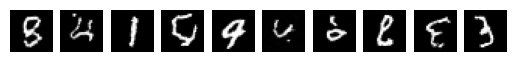

Epoch 91/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0269]


Epoch 91 | Avg Loss: 0.0262


Epoch 92/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0233]


Epoch 92 | Avg Loss: 0.0265


Epoch 93/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0267]


Epoch 93 | Avg Loss: 0.0263


Epoch 94/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0250]


Epoch 94 | Avg Loss: 0.0262


Epoch 95/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0262]


Epoch 95 | Avg Loss: 0.0262


Epoch 96/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0260]


Epoch 96 | Avg Loss: 0.0263


Epoch 97/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0245]


Epoch 97 | Avg Loss: 0.0261


Epoch 98/200: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0263]


Epoch 98 | Avg Loss: 0.0264


Epoch 99/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0253]


Epoch 99 | Avg Loss: 0.0260


Epoch 100/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0257]


Epoch 100 | Avg Loss: 0.0263


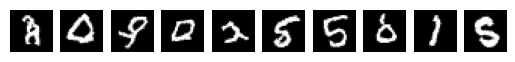

Epoch 101/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0246]


Epoch 101 | Avg Loss: 0.0259


Epoch 102/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0257]


Epoch 102 | Avg Loss: 0.0259


Epoch 103/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0262]


Epoch 103 | Avg Loss: 0.0258


Epoch 104/200: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0252]


Epoch 104 | Avg Loss: 0.0260


Epoch 105/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0250]


Epoch 105 | Avg Loss: 0.0262


Epoch 106/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0257]


Epoch 106 | Avg Loss: 0.0259


Epoch 107/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0258]


Epoch 107 | Avg Loss: 0.0258


Epoch 108/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0260]


Epoch 108 | Avg Loss: 0.0258


Epoch 109/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0256]


Epoch 109 | Avg Loss: 0.0258


Epoch 110/200: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0260]


Epoch 110 | Avg Loss: 0.0255


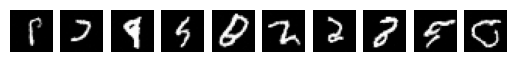

Epoch 111/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0258]


Epoch 111 | Avg Loss: 0.0260


Epoch 112/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0281]


Epoch 112 | Avg Loss: 0.0260


Epoch 113/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0266]


Epoch 113 | Avg Loss: 0.0258


Epoch 114/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0250]


Epoch 114 | Avg Loss: 0.0258


Epoch 115/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0258]


Epoch 115 | Avg Loss: 0.0259


Epoch 116/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0255]


Epoch 116 | Avg Loss: 0.0258


Epoch 117/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0258]


Epoch 117 | Avg Loss: 0.0257


Epoch 118/200: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0254]


Epoch 118 | Avg Loss: 0.0258


Epoch 119/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0249]


Epoch 119 | Avg Loss: 0.0259


Epoch 120/200: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0291]


Epoch 120 | Avg Loss: 0.0256


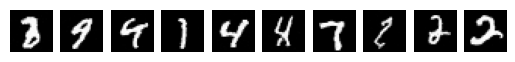

Epoch 121/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0246]


Epoch 121 | Avg Loss: 0.0257


Epoch 122/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0249]


Epoch 122 | Avg Loss: 0.0257


Epoch 123/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0249]


Epoch 123 | Avg Loss: 0.0255


Epoch 124/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0260]


Epoch 124 | Avg Loss: 0.0258


Epoch 125/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0246]


Epoch 125 | Avg Loss: 0.0255


Epoch 126/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0265]


Epoch 126 | Avg Loss: 0.0257


Epoch 127/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0250]


Epoch 127 | Avg Loss: 0.0255


Epoch 128/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0238]


Epoch 128 | Avg Loss: 0.0255


Epoch 129/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0261]


Epoch 129 | Avg Loss: 0.0252


Epoch 130/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0254]


Epoch 130 | Avg Loss: 0.0255


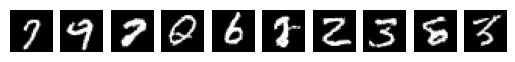

Epoch 131/200: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0240]


Epoch 131 | Avg Loss: 0.0253


Epoch 132/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0231]


Epoch 132 | Avg Loss: 0.0254


Epoch 133/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0261]


Epoch 133 | Avg Loss: 0.0251


Epoch 134/200: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0248]


Epoch 134 | Avg Loss: 0.0255


Epoch 135/200: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0254]


Epoch 135 | Avg Loss: 0.0250


Epoch 136/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0272]


Epoch 136 | Avg Loss: 0.0252


Epoch 137/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0262]


Epoch 137 | Avg Loss: 0.0255


Epoch 138/200: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0243]


Epoch 138 | Avg Loss: 0.0252


Epoch 139/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0239]


Epoch 139 | Avg Loss: 0.0253


Epoch 140/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0258]


Epoch 140 | Avg Loss: 0.0250


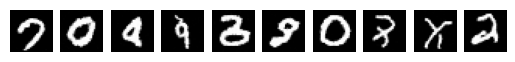

Epoch 141/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0242]


Epoch 141 | Avg Loss: 0.0252


Epoch 142/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0248]


Epoch 142 | Avg Loss: 0.0253


Epoch 143/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0266]


Epoch 143 | Avg Loss: 0.0252


Epoch 144/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0240]


Epoch 144 | Avg Loss: 0.0253


Epoch 145/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0249]


Epoch 145 | Avg Loss: 0.0252


Epoch 146/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0227]


Epoch 146 | Avg Loss: 0.0250


Epoch 147/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0246]


Epoch 147 | Avg Loss: 0.0252


Epoch 148/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0255]


Epoch 148 | Avg Loss: 0.0249


Epoch 149/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0259]


Epoch 149 | Avg Loss: 0.0249


Epoch 150/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0263]


Epoch 150 | Avg Loss: 0.0249


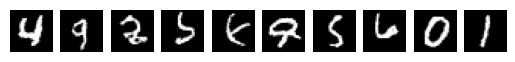

Epoch 151/200: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0245]


Epoch 151 | Avg Loss: 0.0252


Epoch 152/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0253]


Epoch 152 | Avg Loss: 0.0250


Epoch 153/200: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0243]


Epoch 153 | Avg Loss: 0.0250


Epoch 154/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0249]


Epoch 154 | Avg Loss: 0.0248


Epoch 155/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0242]


Epoch 155 | Avg Loss: 0.0249


Epoch 156/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0258]


Epoch 156 | Avg Loss: 0.0251


Epoch 157/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0275]


Epoch 157 | Avg Loss: 0.0252


Epoch 158/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0259]


Epoch 158 | Avg Loss: 0.0248


Epoch 159/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0251]


Epoch 159 | Avg Loss: 0.0249


Epoch 160/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0252]


Epoch 160 | Avg Loss: 0.0250


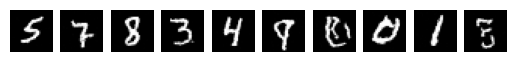

Epoch 161/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0251]


Epoch 161 | Avg Loss: 0.0247


Epoch 162/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0244]


Epoch 162 | Avg Loss: 0.0250


Epoch 163/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0261]


Epoch 163 | Avg Loss: 0.0246


Epoch 164/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0248]


Epoch 164 | Avg Loss: 0.0247


Epoch 165/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0239]


Epoch 165 | Avg Loss: 0.0248


Epoch 166/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0248]


Epoch 166 | Avg Loss: 0.0245


Epoch 167/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0234]


Epoch 167 | Avg Loss: 0.0248


Epoch 168/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0232]


Epoch 168 | Avg Loss: 0.0247


Epoch 169/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0228]


Epoch 169 | Avg Loss: 0.0247


Epoch 170/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0261]


Epoch 170 | Avg Loss: 0.0247


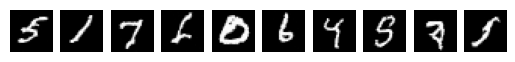

Epoch 171/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0258]


Epoch 171 | Avg Loss: 0.0248


Epoch 172/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0231]


Epoch 172 | Avg Loss: 0.0245


Epoch 173/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0239]


Epoch 173 | Avg Loss: 0.0248


Epoch 174/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0236]


Epoch 174 | Avg Loss: 0.0247


Epoch 175/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0260]


Epoch 175 | Avg Loss: 0.0257


Epoch 176/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0239]


Epoch 176 | Avg Loss: 0.0247


Epoch 177/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0247]


Epoch 177 | Avg Loss: 0.0248


Epoch 178/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0240]


Epoch 178 | Avg Loss: 0.0247


Epoch 179/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0251]


Epoch 179 | Avg Loss: 0.0246


Epoch 180/200: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0250]


Epoch 180 | Avg Loss: 0.0245


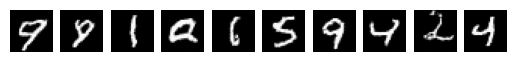

Epoch 181/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0246]


Epoch 181 | Avg Loss: 0.0248


Epoch 182/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0250]


Epoch 182 | Avg Loss: 0.0247


Epoch 183/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0259]


Epoch 183 | Avg Loss: 0.0247


Epoch 184/200: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0246]


Epoch 184 | Avg Loss: 0.0246


Epoch 185/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0232]


Epoch 185 | Avg Loss: 0.0245


Epoch 186/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0254]


Epoch 186 | Avg Loss: 0.0247


Epoch 187/200: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0244]


Epoch 187 | Avg Loss: 0.0242


Epoch 188/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0239]


Epoch 188 | Avg Loss: 0.0246


Epoch 189/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0264]


Epoch 189 | Avg Loss: 0.0248


Epoch 190/200: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0247]


Epoch 190 | Avg Loss: 0.0247


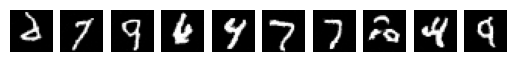

Epoch 191/200: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0246]


Epoch 191 | Avg Loss: 0.0247


Epoch 192/200: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0225]


Epoch 192 | Avg Loss: 0.0244


Epoch 193/200: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0223]


Epoch 193 | Avg Loss: 0.0245


Epoch 194/200: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0253]


Epoch 194 | Avg Loss: 0.0244


Epoch 195/200: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0239]


Epoch 195 | Avg Loss: 0.0245


Epoch 196/200: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0250]


Epoch 196 | Avg Loss: 0.0247


Epoch 197/200: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0242]


Epoch 197 | Avg Loss: 0.0245


Epoch 198/200: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0250]


Epoch 198 | Avg Loss: 0.0243


Epoch 199/200: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0245]


Epoch 199 | Avg Loss: 0.0246


Epoch 200/200: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0252]


Epoch 200 | Avg Loss: 0.0242


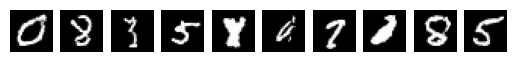

Training completed!


In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
best_loss = float("inf")
sample = True
for epoch in range(config["epochs"]):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        # Training step
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config["max_grad_norm"]
        )  # prevent gradient exploding
        optimizer.step()

        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    if sample and (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(1, 28, 28))
            for i, img in enumerate(sampled_images):
                plt.subplot(1, 10, i + 1)
                plt.imshow(img.squeeze().cpu(), cmap="gray")
                plt.axis("off")
            plt.show()

    if (epoch + 1) % config["save_interval"] == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": avg_loss,
            },
            f"checkpoints/checkpoint_{epoch+1:03d}.pth",
        )

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")

Epoch 201/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0232]


Epoch 1 | Avg Loss: 0.0245


Epoch 202/401: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0243]


Epoch 2 | Avg Loss: 0.0246


Epoch 203/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0234]


Epoch 3 | Avg Loss: 0.0243


Epoch 204/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0232]


Epoch 4 | Avg Loss: 0.0244


Epoch 205/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0226]


Epoch 5 | Avg Loss: 0.0243


Epoch 206/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0233]


Epoch 6 | Avg Loss: 0.0245


Epoch 207/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0250]


Epoch 7 | Avg Loss: 0.0244


Epoch 208/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0260]


Epoch 8 | Avg Loss: 0.0244


Epoch 209/401: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0239]


Epoch 9 | Avg Loss: 0.0245


Epoch 210/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0251]


Epoch 10 | Avg Loss: 0.0244


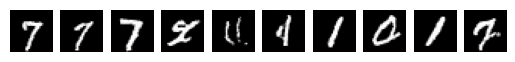

Epoch 211/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0247]


Epoch 11 | Avg Loss: 0.0244


Epoch 212/401: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0235]


Epoch 12 | Avg Loss: 0.0244


Epoch 213/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0228]


Epoch 13 | Avg Loss: 0.0242


Epoch 214/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0231]


Epoch 14 | Avg Loss: 0.0243


Epoch 215/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0237]


Epoch 15 | Avg Loss: 0.0244


Epoch 216/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0248]


Epoch 16 | Avg Loss: 0.0243


Epoch 217/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0249]


Epoch 17 | Avg Loss: 0.0242


Epoch 218/401: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0230]


Epoch 18 | Avg Loss: 0.0242


Epoch 219/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0252]


Epoch 19 | Avg Loss: 0.0241


Epoch 220/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0228]


Epoch 20 | Avg Loss: 0.0243


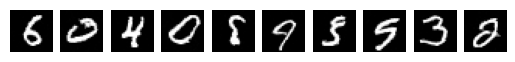

Epoch 221/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0254]


Epoch 21 | Avg Loss: 0.0242


Epoch 222/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0255]


Epoch 22 | Avg Loss: 0.0242


Epoch 223/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0244]


Epoch 23 | Avg Loss: 0.0245


Epoch 224/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0241]


Epoch 24 | Avg Loss: 0.0243


Epoch 225/401: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0245]


Epoch 25 | Avg Loss: 0.0241


Epoch 226/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0236]


Epoch 26 | Avg Loss: 0.0242


Epoch 227/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0240]


Epoch 27 | Avg Loss: 0.0241


Epoch 228/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0234]


Epoch 28 | Avg Loss: 0.0241


Epoch 229/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0237]


Epoch 29 | Avg Loss: 0.0241


Epoch 230/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0239]


Epoch 30 | Avg Loss: 0.0241


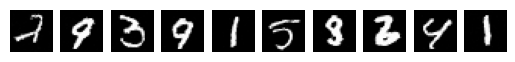

Epoch 231/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0247]


Epoch 31 | Avg Loss: 0.0241


Epoch 232/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0231]


Epoch 32 | Avg Loss: 0.0243


Epoch 233/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0236]


Epoch 33 | Avg Loss: 0.0242


Epoch 234/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0231]


Epoch 34 | Avg Loss: 0.0243


Epoch 235/401: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0220]


Epoch 35 | Avg Loss: 0.0239


Epoch 236/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0264]


Epoch 36 | Avg Loss: 0.0242


Epoch 237/401: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0236]


Epoch 37 | Avg Loss: 0.0240


Epoch 238/401: 100%|██████████| 47/47 [00:05<00:00,  7.83it/s, Loss=0.0239]


Epoch 38 | Avg Loss: 0.0242


Epoch 239/401: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0271]


Epoch 39 | Avg Loss: 0.0242


Epoch 240/401: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0233]


Epoch 40 | Avg Loss: 0.0240


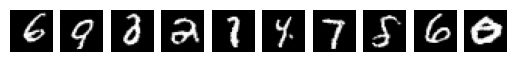

Epoch 241/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0237]


Epoch 41 | Avg Loss: 0.0240


Epoch 242/401: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0225]


Epoch 42 | Avg Loss: 0.0241


Epoch 243/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0243]


Epoch 43 | Avg Loss: 0.0241


Epoch 244/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0248]


Epoch 44 | Avg Loss: 0.0239


Epoch 245/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0231]


Epoch 45 | Avg Loss: 0.0240


Epoch 246/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0241]


Epoch 46 | Avg Loss: 0.0241


Epoch 247/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0252]


Epoch 47 | Avg Loss: 0.0242


Epoch 248/401: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0247]


Epoch 48 | Avg Loss: 0.0242


Epoch 249/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0221]


Epoch 49 | Avg Loss: 0.0237


Epoch 250/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0227]


Epoch 50 | Avg Loss: 0.0241


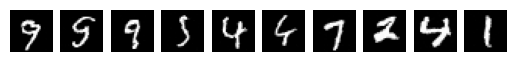

Epoch 251/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0254]


Epoch 51 | Avg Loss: 0.0239


Epoch 252/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0244]


Epoch 52 | Avg Loss: 0.0239


Epoch 253/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0236]


Epoch 53 | Avg Loss: 0.0240


Epoch 254/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0237]


Epoch 54 | Avg Loss: 0.0241


Epoch 255/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0225]


Epoch 55 | Avg Loss: 0.0241


Epoch 256/401: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0245]


Epoch 56 | Avg Loss: 0.0242


Epoch 257/401: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0232]


Epoch 57 | Avg Loss: 0.0240


Epoch 258/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0261]


Epoch 58 | Avg Loss: 0.0240


Epoch 259/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0257]


Epoch 59 | Avg Loss: 0.0241


Epoch 260/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0230]


Epoch 60 | Avg Loss: 0.0242


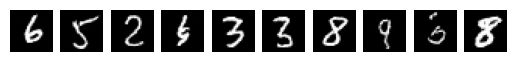

Epoch 261/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0239]


Epoch 61 | Avg Loss: 0.0238


Epoch 262/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0237]


Epoch 62 | Avg Loss: 0.0239


Epoch 263/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0240]


Epoch 63 | Avg Loss: 0.0240


Epoch 264/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0241]


Epoch 64 | Avg Loss: 0.0241


Epoch 265/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0250]


Epoch 65 | Avg Loss: 0.0239


Epoch 266/401: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0242]


Epoch 66 | Avg Loss: 0.0238


Epoch 267/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0241]


Epoch 67 | Avg Loss: 0.0239


Epoch 268/401: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0231]


Epoch 68 | Avg Loss: 0.0237


Epoch 269/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0232]


Epoch 69 | Avg Loss: 0.0240


Epoch 270/401: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0258]


Epoch 70 | Avg Loss: 0.0238


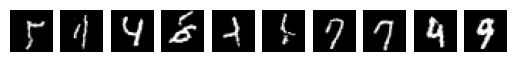

Epoch 271/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0232]


Epoch 71 | Avg Loss: 0.0241


Epoch 272/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0234]


Epoch 72 | Avg Loss: 0.0238


Epoch 273/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0233]


Epoch 73 | Avg Loss: 0.0240


Epoch 274/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0241]


Epoch 74 | Avg Loss: 0.0239


Epoch 275/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0247]


Epoch 75 | Avg Loss: 0.0241


Epoch 276/401: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0243]


Epoch 76 | Avg Loss: 0.0236


Epoch 277/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0230]


Epoch 77 | Avg Loss: 0.0240


Epoch 278/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0223]


Epoch 78 | Avg Loss: 0.0239


Epoch 279/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0231]


Epoch 79 | Avg Loss: 0.0236


Epoch 280/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0244]


Epoch 80 | Avg Loss: 0.0241


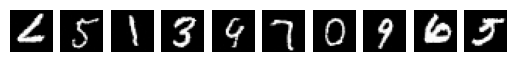

Epoch 281/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0258]


Epoch 81 | Avg Loss: 0.0238


Epoch 282/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0220]


Epoch 82 | Avg Loss: 0.0238


Epoch 283/401: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0229]


Epoch 83 | Avg Loss: 0.0234


Epoch 284/401: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0239]


Epoch 84 | Avg Loss: 0.0237


Epoch 285/401: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0232]


Epoch 85 | Avg Loss: 0.0237


Epoch 286/401: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0254]


Epoch 86 | Avg Loss: 0.0238


Epoch 287/401: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0274]


Epoch 87 | Avg Loss: 0.0240


Epoch 288/401: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0238]


Epoch 88 | Avg Loss: 0.0237


Epoch 289/401: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0218]


Epoch 89 | Avg Loss: 0.0237


Epoch 290/401: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0234]


Epoch 90 | Avg Loss: 0.0239


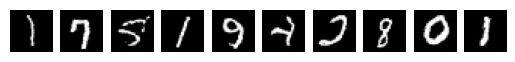

Epoch 291/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0230]


Epoch 91 | Avg Loss: 0.0237


Epoch 292/401: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0256]


Epoch 92 | Avg Loss: 0.0237


Epoch 293/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0235]


Epoch 93 | Avg Loss: 0.0237


Epoch 294/401: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0246]


Epoch 94 | Avg Loss: 0.0237


Epoch 295/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0236]


Epoch 95 | Avg Loss: 0.0239


Epoch 296/401: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0244]


Epoch 96 | Avg Loss: 0.0240


Epoch 297/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0252]


Epoch 97 | Avg Loss: 0.0239


Epoch 298/401: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0258]


Epoch 98 | Avg Loss: 0.0239


Epoch 299/401: 100%|██████████| 47/47 [00:06<00:00,  7.83it/s, Loss=0.0247]


Epoch 99 | Avg Loss: 0.0235


Epoch 300/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0222]


Epoch 100 | Avg Loss: 0.0239


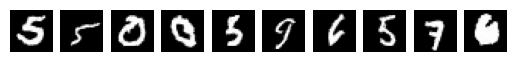

Epoch 301/401: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0249]


Epoch 101 | Avg Loss: 0.0235


Epoch 302/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0240]


Epoch 102 | Avg Loss: 0.0235


Epoch 303/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0241]


Epoch 103 | Avg Loss: 0.0237


Epoch 304/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0256]


Epoch 104 | Avg Loss: 0.0236


Epoch 305/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0241]


Epoch 105 | Avg Loss: 0.0237


Epoch 306/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0237]


Epoch 106 | Avg Loss: 0.0237


Epoch 307/401: 100%|██████████| 47/47 [00:06<00:00,  7.75it/s, Loss=0.0236]


Epoch 107 | Avg Loss: 0.0236


Epoch 308/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0235]


Epoch 108 | Avg Loss: 0.0235


Epoch 309/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0256]


Epoch 109 | Avg Loss: 0.0238


Epoch 310/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0240]


Epoch 110 | Avg Loss: 0.0238


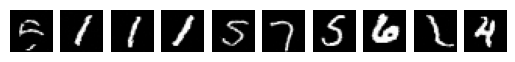

Epoch 311/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0228]


Epoch 111 | Avg Loss: 0.0235


Epoch 312/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0239]


Epoch 112 | Avg Loss: 0.0239


Epoch 313/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0238]


Epoch 113 | Avg Loss: 0.0237


Epoch 314/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0250]


Epoch 114 | Avg Loss: 0.0239


Epoch 315/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0224]


Epoch 115 | Avg Loss: 0.0239


Epoch 316/401: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0250]


Epoch 116 | Avg Loss: 0.0236


Epoch 317/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0229]


Epoch 117 | Avg Loss: 0.0236


Epoch 318/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0239]


Epoch 118 | Avg Loss: 0.0235


Epoch 319/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0235]


Epoch 119 | Avg Loss: 0.0234


Epoch 320/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0243]


Epoch 120 | Avg Loss: 0.0233


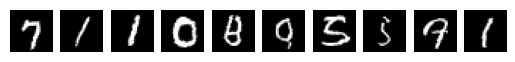

Epoch 321/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0224]


Epoch 121 | Avg Loss: 0.0236


Epoch 322/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0210]


Epoch 122 | Avg Loss: 0.0236


Epoch 323/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0233]


Epoch 123 | Avg Loss: 0.0234


Epoch 324/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0230]


Epoch 124 | Avg Loss: 0.0235


Epoch 325/401: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0248]


Epoch 125 | Avg Loss: 0.0236


Epoch 326/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0242]


Epoch 126 | Avg Loss: 0.0235


Epoch 327/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0223]


Epoch 127 | Avg Loss: 0.0236


Epoch 328/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0235]


Epoch 128 | Avg Loss: 0.0238


Epoch 329/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0247]


Epoch 129 | Avg Loss: 0.0239


Epoch 330/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0250]


Epoch 130 | Avg Loss: 0.0234


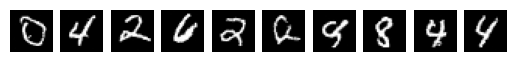

Epoch 331/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0247]


Epoch 131 | Avg Loss: 0.0236


Epoch 332/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0239]


Epoch 132 | Avg Loss: 0.0234


Epoch 333/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0231]


Epoch 133 | Avg Loss: 0.0236


Epoch 334/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0240]


Epoch 134 | Avg Loss: 0.0237


Epoch 335/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0223]


Epoch 135 | Avg Loss: 0.0236


Epoch 336/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0260]


Epoch 136 | Avg Loss: 0.0238


Epoch 337/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0238]


Epoch 137 | Avg Loss: 0.0234


Epoch 338/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0234]


Epoch 138 | Avg Loss: 0.0234


Epoch 339/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0226]


Epoch 139 | Avg Loss: 0.0237


Epoch 340/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0230]


Epoch 140 | Avg Loss: 0.0237


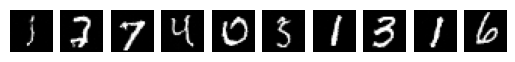

Epoch 341/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0233]


Epoch 141 | Avg Loss: 0.0236


Epoch 342/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0225]


Epoch 142 | Avg Loss: 0.0235


Epoch 343/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0232]


Epoch 143 | Avg Loss: 0.0235


Epoch 344/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0242]


Epoch 144 | Avg Loss: 0.0235


Epoch 345/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0231]


Epoch 145 | Avg Loss: 0.0235


Epoch 346/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0224]


Epoch 146 | Avg Loss: 0.0234


Epoch 347/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0227]


Epoch 147 | Avg Loss: 0.0233


Epoch 348/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0237]


Epoch 148 | Avg Loss: 0.0235


Epoch 349/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0237]


Epoch 149 | Avg Loss: 0.0236


Epoch 350/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0225]


Epoch 150 | Avg Loss: 0.0237


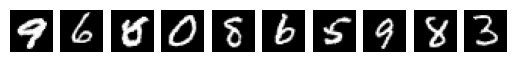

Epoch 351/401: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0219]


Epoch 151 | Avg Loss: 0.0237


Epoch 352/401: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0246]


Epoch 152 | Avg Loss: 0.0235


Epoch 353/401: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0240]


Epoch 153 | Avg Loss: 0.0234


Epoch 354/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0232]


Epoch 154 | Avg Loss: 0.0231


Epoch 355/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0231]


Epoch 155 | Avg Loss: 0.0234


Epoch 356/401: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0225]


Epoch 156 | Avg Loss: 0.0234


Epoch 357/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0224]


Epoch 157 | Avg Loss: 0.0237


Epoch 358/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0232]


Epoch 158 | Avg Loss: 0.0235


Epoch 359/401: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0227]


Epoch 159 | Avg Loss: 0.0234


Epoch 360/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0229]


Epoch 160 | Avg Loss: 0.0233


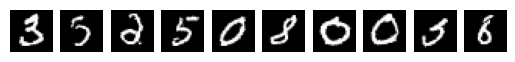

Epoch 361/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0223]


Epoch 161 | Avg Loss: 0.0234


Epoch 362/401: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0245]


Epoch 162 | Avg Loss: 0.0234


Epoch 363/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0238]


Epoch 163 | Avg Loss: 0.0234


Epoch 364/401: 100%|██████████| 47/47 [00:06<00:00,  7.82it/s, Loss=0.0222]


Epoch 164 | Avg Loss: 0.0232


Epoch 365/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0232]


Epoch 165 | Avg Loss: 0.0233


Epoch 366/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0224]


Epoch 166 | Avg Loss: 0.0234


Epoch 367/401: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0233]


Epoch 167 | Avg Loss: 0.0236


Epoch 368/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0242]


Epoch 168 | Avg Loss: 0.0236


Epoch 369/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0245]


Epoch 169 | Avg Loss: 0.0236


Epoch 370/401: 100%|██████████| 47/47 [00:06<00:00,  7.77it/s, Loss=0.0239]


Epoch 170 | Avg Loss: 0.0232


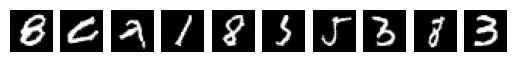

Epoch 371/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0229]


Epoch 171 | Avg Loss: 0.0234


Epoch 372/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0228]


Epoch 172 | Avg Loss: 0.0234


Epoch 373/401: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0230]


Epoch 173 | Avg Loss: 0.0232


Epoch 374/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0240]


Epoch 174 | Avg Loss: 0.0232


Epoch 375/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0239]


Epoch 175 | Avg Loss: 0.0233


Epoch 376/401: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0221]


Epoch 176 | Avg Loss: 0.0236


Epoch 377/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0242]


Epoch 177 | Avg Loss: 0.0235


Epoch 378/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0237]


Epoch 178 | Avg Loss: 0.0234


Epoch 379/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0222]


Epoch 179 | Avg Loss: 0.0232


Epoch 380/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0230]


Epoch 180 | Avg Loss: 0.0236


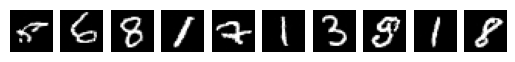

Epoch 381/401: 100%|██████████| 47/47 [00:06<00:00,  7.76it/s, Loss=0.0212]


Epoch 181 | Avg Loss: 0.0234


Epoch 382/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0222]


Epoch 182 | Avg Loss: 0.0233


Epoch 383/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0249]


Epoch 183 | Avg Loss: 0.0233


Epoch 384/401: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0220]


Epoch 184 | Avg Loss: 0.0231


Epoch 385/401: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0237]


Epoch 185 | Avg Loss: 0.0233


Epoch 386/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0254]


Epoch 186 | Avg Loss: 0.0234


Epoch 387/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0231]


Epoch 187 | Avg Loss: 0.0233


Epoch 388/401: 100%|██████████| 47/47 [00:05<00:00,  7.89it/s, Loss=0.0241]


Epoch 188 | Avg Loss: 0.0234


Epoch 389/401: 100%|██████████| 47/47 [00:05<00:00,  7.88it/s, Loss=0.0232]


Epoch 189 | Avg Loss: 0.0234


Epoch 390/401: 100%|██████████| 47/47 [00:06<00:00,  7.81it/s, Loss=0.0228]


Epoch 190 | Avg Loss: 0.0233


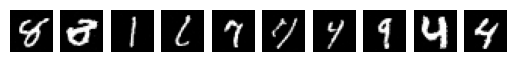

Epoch 391/401: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, Loss=0.0232]


Epoch 191 | Avg Loss: 0.0231


Epoch 392/401: 100%|██████████| 47/47 [00:06<00:00,  7.79it/s, Loss=0.0229]


Epoch 192 | Avg Loss: 0.0232


Epoch 393/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0225]


Epoch 193 | Avg Loss: 0.0234


Epoch 394/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0229]


Epoch 194 | Avg Loss: 0.0234


Epoch 395/401: 100%|██████████| 47/47 [00:06<00:00,  7.78it/s, Loss=0.0228]


Epoch 195 | Avg Loss: 0.0233


Epoch 396/401: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, Loss=0.0247]


Epoch 196 | Avg Loss: 0.0232


Epoch 397/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0228]


Epoch 197 | Avg Loss: 0.0234


Epoch 398/401: 100%|██████████| 47/47 [00:06<00:00,  7.80it/s, Loss=0.0232]


Epoch 198 | Avg Loss: 0.0233


Epoch 399/401: 100%|██████████| 47/47 [00:05<00:00,  7.85it/s, Loss=0.0239]


Epoch 199 | Avg Loss: 0.0233


Epoch 400/401: 100%|██████████| 47/47 [00:05<00:00,  7.86it/s, Loss=0.0225]


Epoch 200 | Avg Loss: 0.0233


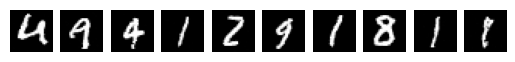

Training completed!


In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
best_loss = float("inf")
sample = True
for epoch in range(config["epochs"]):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+201}/{config['epochs']+201}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)

        # Training step
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config["max_grad_norm"]
        )  # prevent gradient exploding
        optimizer.step()

        # Logging
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    if sample and (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(1, 28, 28))
            for i, img in enumerate(sampled_images):
                plt.subplot(1, 10, i + 1)
                plt.imshow(img.squeeze().cpu(), cmap="gray")
                plt.axis("off")
            plt.show()

    if (epoch + 1) % config["save_interval"] == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": avg_loss,
            },
            f"checkpoints/checkpoint_{epoch+201:03d}.pth",
        )

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "checkpoints/best_model.pth")


torch.save(model.state_dict(), "mnist_diffusion_final.pth")
print("Training completed!")